# Child Mind Institute - Detection of events

In this notebook we will conduct a complete analysis of the challenge of the Child Mind Instutite<br>
https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states<br>
The goal is to detect sleep onset and wake from wrist-worn accelerometer data<br>

In [2]:
# more details about the project
# accelerometer

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow
import fastparquet

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import average_precision_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from utils import *

## 0- Load data

The kaggle competition provided 4 files:<br>
- train_series.parquet, the train set<br>
- test_series.parquet, the test set used to evaluate participants on kaggle<br>
- train_events.csv, the labelling of train_series<br>
- sample_submission.csv, an example of what we will submit to the competition

For now we will only load train_series.parquet and train_events to make a data analysis and train our model

### Train_series

In [23]:
fp_train = os.path.join("..", "input", "train_series.parquet")
data = pd.read_parquet(fp_train)

### Train_events

In [120]:
fp_events = os.path.join("..", "input", "train_events.csv")
data_events = pd.read_csv(fp_events)

## I- Exploratoty Data Analysis

### Features

In [25]:
data.head(5)

series_id  step                 timestamp  anglez    enmo
0  038441c925bb     0  2018-08-14T15:30:00-0400  2.6367  0.0217
1  038441c925bb     1  2018-08-14T15:30:05-0400  2.6368  0.0215
2  038441c925bb     2  2018-08-14T15:30:10-0400  2.6370  0.0216
3  038441c925bb     3  2018-08-14T15:30:15-0400  2.6368  0.0213
4  038441c925bb     4  2018-08-14T15:30:20-0400  2.6368  0.0215

In the train set we have: <br>
- series_id : a string to indentify a series (one person). We have several days of data for each series_id<br>
- step : a counter for each record of each series. It is unique in a series but not in the database<br>
- timestamp : the time of the record. The data have been recorded every 5 seconds.<br>
- anglez : a metric derived from individual accelerometer components that refers to the angle of the arm relative to the vertical axis of the body.<br>
- enmo : the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero.

In [26]:
data_events.head(5)

series_id  night   event     step                 timestamp
0  038441c925bb      1   onset   4992.0  2018-08-14T22:26:00-0400
1  038441c925bb      1  wakeup  10932.0  2018-08-15T06:41:00-0400
2  038441c925bb      2   onset  20244.0  2018-08-15T19:37:00-0400
3  038441c925bb      2  wakeup  27492.0  2018-08-16T05:41:00-0400
4  038441c925bb      3   onset  39996.0  2018-08-16T23:03:00-0400

In the labelled train set we have: <br>
- series_id : the same column as in the train set<br>
- night : a counter for the nights in one series
- event : the event corresponding to the row (onset or wakeup)
- step and timestamp : the same columns as in train set

In [28]:
print("Shape of train set:", data.shape)
print("Shape of labelled train set:", data_events.shape)

Shape of train set: (127946340, 5)
Shape of labelled train set: (14508, 5)


The labelled train set is smaller than the train set because there are only the rows where an event occur.<br>
We try to predict events happening about 0.01% of the time

In [36]:
print(f"Total time recorded: {5 * 127946340} seconds.")
print(f"Total days recorded: {5 * 127946340 / 3600 / 24:.2f}.")
print("Those days are not consecutives since the data was recorded on several people.")

Total time recorded: 639731700 seconds.
Total days recorded: 7404.30.
Those days are not consecutives since the data was recorded on several people.


In [63]:
print("Number of series in train set:", data["series_id"].nunique())
print("Number of series in labelled train set:", data_events["series_id"].nunique())

Number of series in train set: 277
Number of series in labelled train set: 277


In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   series_id  object 
 1   step       uint32 
 2   timestamp  object 
 3   anglez     float32
 4   enmo       float32
dtypes: float32(2), object(2), uint32(1)
memory usage: 3.3+ GB


In [38]:
data_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   series_id  14508 non-null  object 
 1   night      14508 non-null  int64  
 2   event      14508 non-null  object 
 3   step       9585 non-null   float64
 4   timestamp  9585 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 566.8+ KB


In [39]:
data.describe()

step        anglez          enmo
count  1.279463e+08  1.279463e+08  1.279463e+08
mean   2.548048e+05 -8.810453e+00  4.131503e-02
std    1.778930e+05  3.552188e+01  1.018289e-01
min    0.000000e+00 -9.000000e+01  0.000000e+00
25%    1.158120e+05 -3.185890e+01  1.300000e-03
50%    2.345190e+05 -9.597900e+00  1.720000e-02
75%    3.571960e+05  1.130020e+01  4.370000e-02
max    1.433879e+06  9.000000e+01  1.143370e+01

In [40]:
data_events.describe()

night           step
count  14508.000000    9585.000000
mean      15.120072  214352.123944
std       10.286758  141268.408192
min        1.000000     936.000000
25%        7.000000   95436.000000
50%       14.000000  200604.000000
75%       21.000000  317520.000000
max       84.000000  739392.000000

### Missing values

In [45]:
print("Missing values in train set:")
print(data.isna().sum())
print("Missing values in labelled train set:")
print(data_events.isna().sum())

Missing values in train set:
series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64
Missing values in labelled train set:
series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64


In [60]:
data_events[data_events["step"].isna()].head(5)

series_id  night   event  step timestamp
8   038441c925bb      5   onset   NaN       NaN
9   038441c925bb      5  wakeup   NaN       NaN
16  038441c925bb      9   onset   NaN       NaN
17  038441c925bb      9  wakeup   NaN       NaN
26  038441c925bb     14   onset   NaN       NaN

Where step is missing, timestamp is missing too.<br>
We know which event occured but we don't know exaclty when.<br>
Maybe there wasn't time to label everything or the person couldn't label precisely.

 Since the data is too large to work with all of it we will select only series with no missing values.

### Selection of series without na values

For easy reading we will use the function get_series(data, id) defined in utils.py.<br>
It returns the series of a given id.

In [5]:
# create a list of all the series_id
list_id = data_events["series_id"].unique()

In [6]:
# get series id for series withoug na values
list_no_na = []
for id in list_id:
    df_tmp = get_series(data_events, id)
    if df_tmp.isna().sum().sum() == 0:   # no na values
        list_no_na.append(id)

In [18]:
print(f"We have {len(list_no_na)} series without na values")

We have 37 series without na values


### Visualization

In [81]:
# select a series for visualization
id_viz = list_no_na[0]
data_viz = get_series(data, id_viz)
data_events_viz = get_series(data_events, id_viz)
onset_viz = data_events_viz[data_events_viz["event"] == "onset"]
wakeup_viz = data_events_viz[data_events_viz["event"] == "wakeup"]

In [120]:
max(data_viz["enmo"])

2.96560001373291

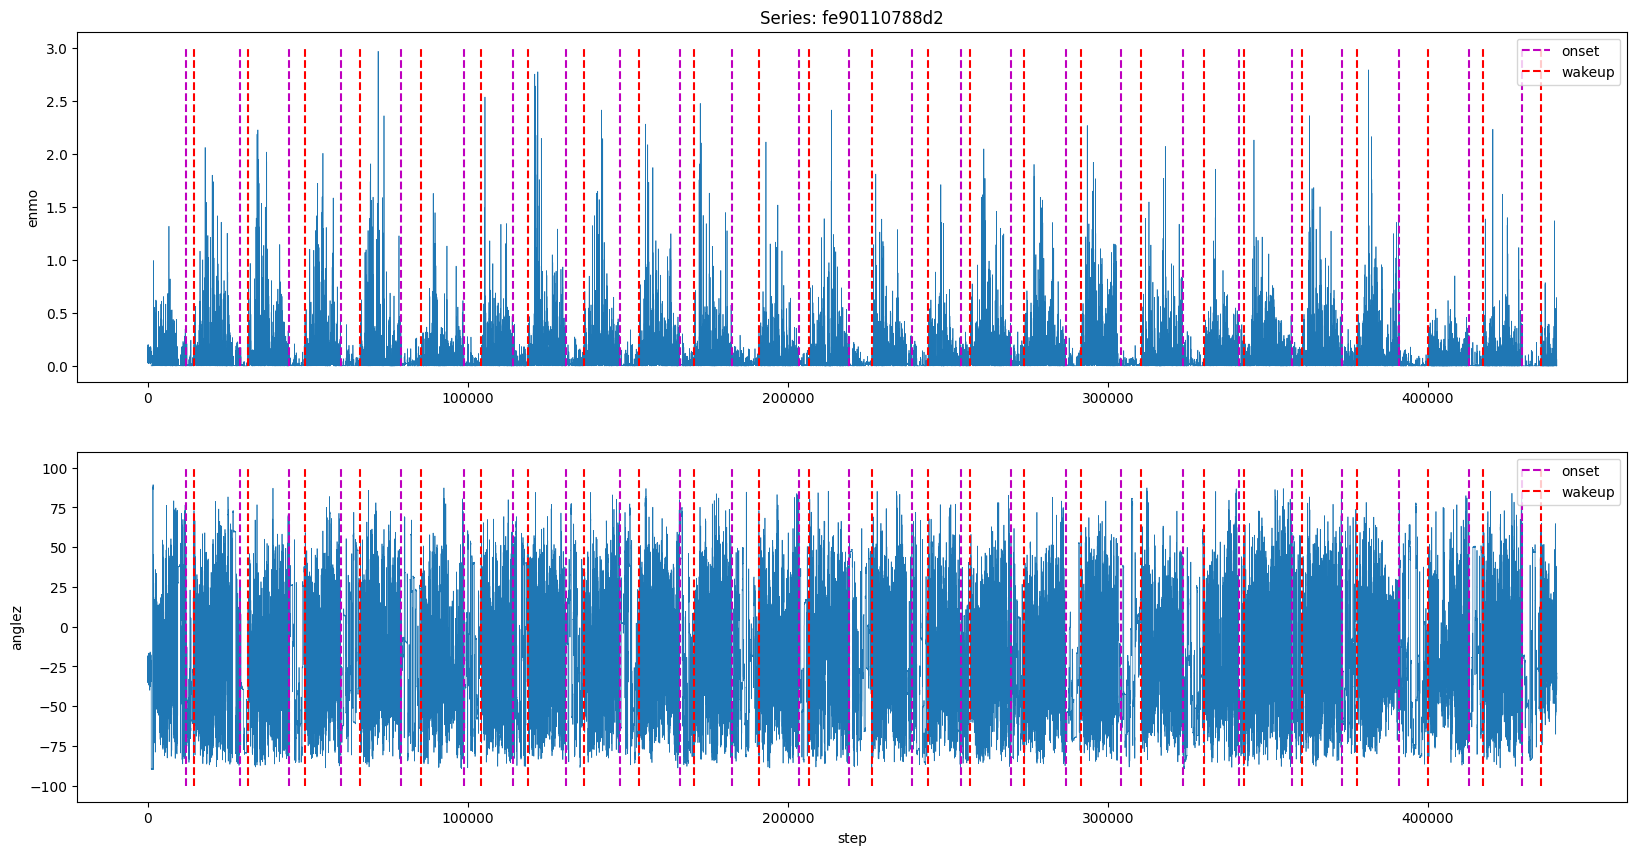

In [123]:
plt.subplots(figsize=(20, 10))


plt.subplot(2, 1, 1)
# plot enmo
plt.plot(data_viz["step"], data_viz["enmo"], linewidth=0.5)
# plot events onset
plt.vlines(x=onset_viz["step"].values, ymin=0, ymax=3, colors = 'm', label = "onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_viz["step"].values, ymin=0, ymax=3, colors = 'r', label = "wakeup", linestyles="dashed")
plt.ylabel("enmo")
plt.legend()

plt.title(f"Series: {id}")

plt.subplot(2, 1, 2)
# plot anglez
plt.plot(data_viz["step"], data_viz["anglez"], linewidth=0.5)
# plot events onset
plt.vlines(x=onset_viz["step"].values, ymin=-100, ymax=100, colors = 'm', label = "onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_viz["step"].values, ymin=-100, ymax=100, colors = 'r', label = "wakeup", linestyles="dashed")
plt.ylabel("anglez")
plt.xlabel("step")
plt.legend()

plt.show()

In [152]:
print(f"One day = {12 * 60 * 24} rows.")

One day = 17280 rows.


In [148]:
# select a fragment of same series for a closer look
start_id = 100000
end_id = start_id + 17280 * 3
data_zoom = data_viz[start_id: end_id]
event_zoom = data_events_viz[data_events_viz["step"].isin(data_zoom["step"])]
onset_zoom = event_zoom[event_zoom["event"] == "onset"]
wakeup_zoom = event_zoom[event_zoom["event"] == "wakeup"]

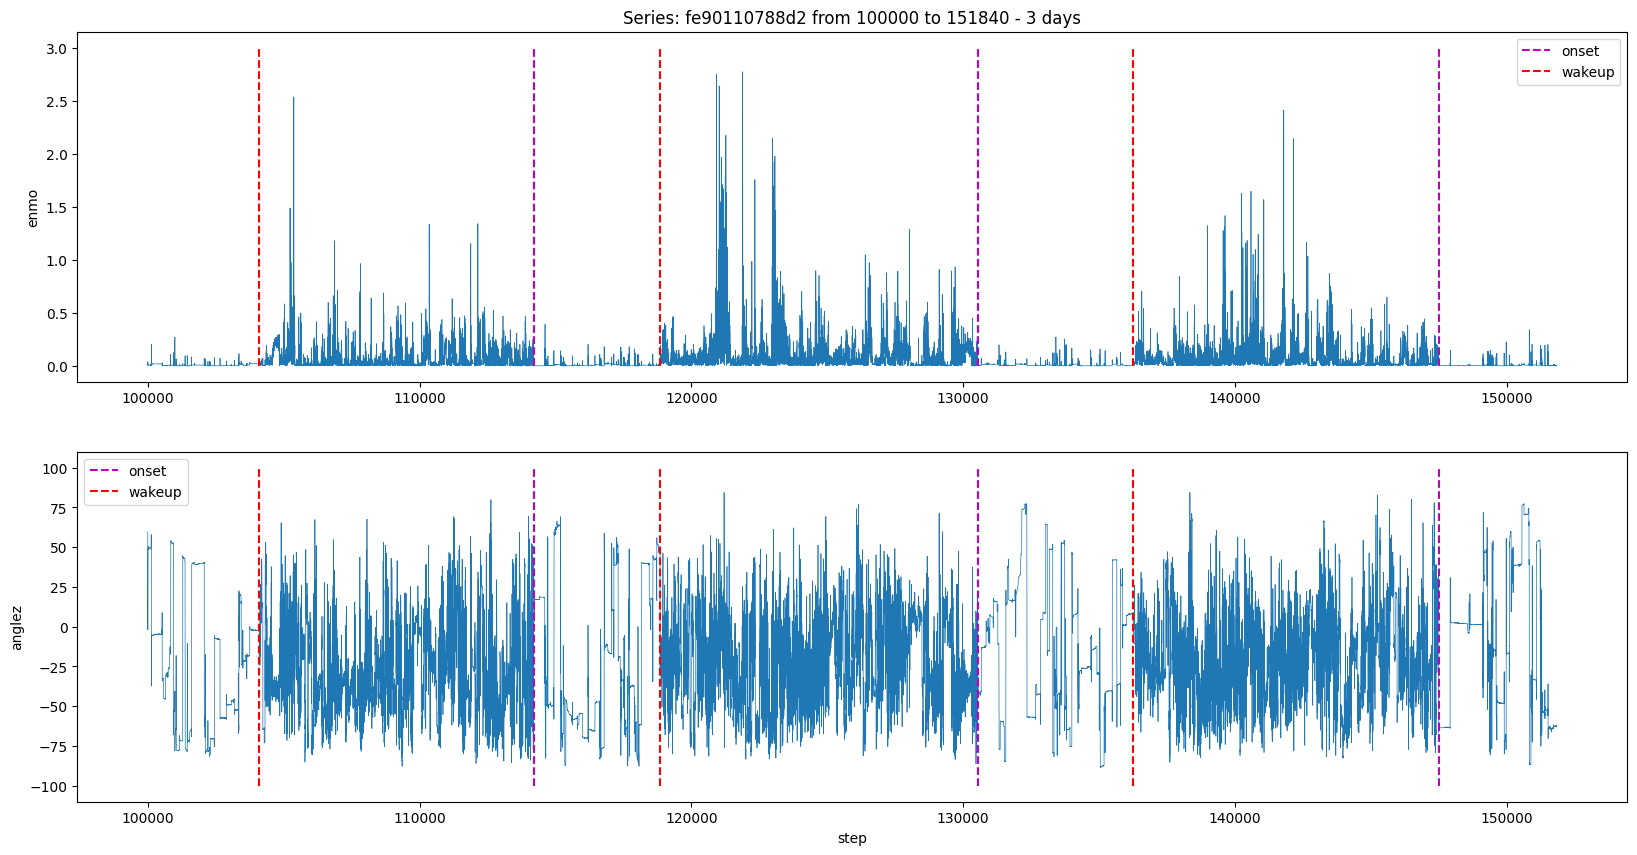

In [150]:
plt.subplots(figsize=(20, 10))


plt.subplot(2, 1, 1)
# plot enmo
plt.plot(data_zoom["step"], data_zoom["enmo"], linewidth=0.5)
# plot events onset
plt.vlines(x=onset_zoom["step"].values, ymin=0, ymax=3, colors = 'm', label = "onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_zoom["step"].values, ymin=0, ymax=3, colors = 'r', label = "wakeup", linestyles="dashed")
plt.ylabel("enmo")
plt.legend()

plt.title(f"Series: {id} from {start_id} to {end_id} - 3 days")

plt.subplot(2, 1, 2)
# plot anglez
plt.plot(data_zoom["step"], data_zoom["anglez"], linewidth=0.5)
# plot events onset
plt.vlines(x=onset_zoom["step"].values, ymin=-100, ymax=100, colors = 'm', label = "onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_zoom["step"].values, ymin=-100, ymax=100, colors = 'r', label = "wakeup", linestyles="dashed")
plt.ylabel("anglez")
plt.xlabel("step")
plt.legend()

plt.show()

### Unifinished series

Series a596ad0b82aa and 31011ade7c0a have another kind of missing values: 
it seems that they haven't been labelled to the end.<br>
We will also remove those series.

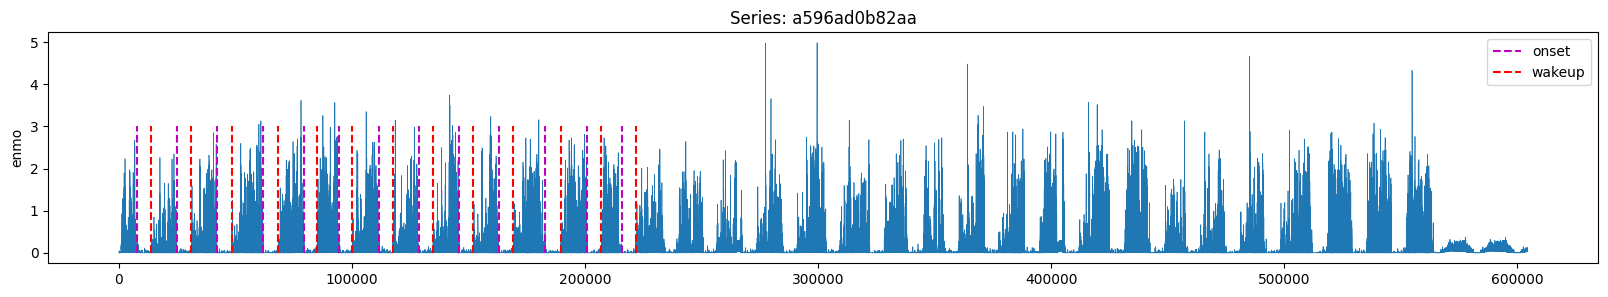

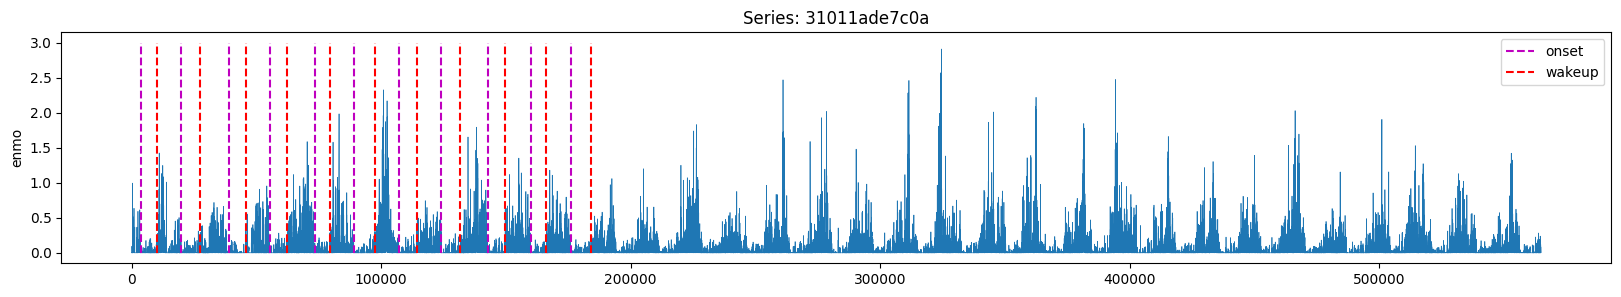

In [198]:
for id in ["a596ad0b82aa", "31011ade7c0a"]:
    data_tmp = get_series(data, id)
    data_event_tmp = get_series(data_events, id)
    onset_viz = data_event_tmp[data_event_tmp["event"] == "onset"]
    wakeup_viz = data_event_tmp[data_event_tmp["event"] == "wakeup"]

    fig, ax = plt.subplots(figsize=(20, 3))
    
    # plot enmo
    plt.plot(data_tmp["step"], data_tmp["enmo"], linewidth=0.5)
    
    # plot events onset
    plt.vlines(x=onset_viz["step"].values, ymin=0, ymax=3, colors = 'm', label = "onset", linestyles="dashed")
    # plot events wakeup
    plt.vlines(x=wakeup_viz["step"].values, ymin=0, ymax=3, colors = 'r', label = "wakeup", linestyles="dashed")
    
    plt.ylabel("enmo")
    plt.legend()

    plt.title(f"Series: {id}")
    
    plt.show()

In [19]:
# remove truncated series
print("len(list_no_na) = ", len(list_no_na))
list_no_na.remove("a596ad0b82aa")
list_no_na.remove("31011ade7c0a")
print("len(list_no_na) = ", len(list_no_na))

len(list_no_na) =  37
len(list_no_na) =  35


### Target encoding

To be able to train a model we need to create a target of the same lenght than our dataset.<br>
We will mege the train set and the label train set and make a new binary column "awake":<br>
1 means the person is awake and 0 means the person sleep.

In [156]:
def create_target(data, df_target):
    """
    Create a data frame from data with new column "awake", using df_target
    for one series
    0: asleep
    1: awake
    pd.DataFrame * pd.DataFrame * str -> pd.DataFrame
    """

    # change step type from float to int in target
    df_target["step"] = df_target["step"].astype("int")

    # create binary column from event columns in target
    df_target["awake"] = df_target["event"].replace({"onset":1,"wakeup":0})

    # merge datasets to create column awake in data on step
    data_result = pd.merge(data, df_target[["step", "awake"]], on="step", how="left")

    # fill na values with backward method
    # onset = 1 so awake == 1 means person is awake
    # wakeup = 0 so awake == 0 means person sleeps
    data_result["awake"] = data_result["awake"].bfill(axis="rows")
    
    # we need to fill end of data frame (couldn't fill backward since ends with na values)
    #  the last event is always a "wakeup"
    data_result['awake'] = data_result['awake'].fillna(1) # awake
    
    # convert float to int
    data_result["awake"] = data_result["awake"].astype("int")
    
    return data_result

In [157]:
def get_data_target(data, df_target, ids):
    """
    Create a data frame from data with new column "awake", using df_target
    for a list series id
    0: asleep
    1: awake
    pd.DataFrame * pd.DataFrame * str -> pd.DataFrame
    """
    data_result = pd.DataFrame()
    for id in ids:
        data_tmp = get_series(data, id)
        target_tmp = get_series(df_target, id)
        new_data = create_target(data_tmp, target_tmp)
        data_result = pd.concat([data_result, new_data], ignore_index=True)

    return data_result

In [202]:
# create dataframe with target
data_target = get_data_target(data, data_events, list_no_na)

In [203]:
data_target.shape

(13165560, 6)

In [204]:
data_target["series_id"].nunique()

35

In [205]:
data_target["awake"].value_counts(normalize=True)

awake
1    0.657828
0    0.342172
Name: proportion, dtype: float64

Now our dataset is not so umbalanced which will be much easier for predictions.

The data set is too big to be saved in a file all at once so we need to split it in two

In [207]:
# save 17 first series
data_17 = data_target[data_target["series_id"].isin(list_no_na[:17])]
fp_17 = os.path.join("..", "output", "data_target_17.csv")
data_17.to_csv(fp_17)

In [208]:
# save 18 last series
data_18 = data_target[data_target["series_id"].isin(list_no_na[17:])]
fp_18 = os.path.join("..", "output", "data_target_18.csv")
data_18.to_csv(fp_18)

## II- Data Engineering

### Load datasets with features

In [7]:
fp_17 = os.path.join("..", "output", "with_target", "data_target_17.csv")
data_17 = pd.read_csv(fp_17)

In [8]:
fp_18 = os.path.join("..", "output", "with_target", "data_target_18.csv")
data_18 = pd.read_csv(fp_18)

In [19]:
data_joined = pd.concat([data_17, data_18])
data_joined = data_joined.drop(columns="Unnamed: 0")
data_joined = data_joined.reset_index(drop=True)

In [21]:
data_joined.head(1)

series_id  step                 timestamp   anglez    enmo  awake
0  08db4255286f     0  2018-11-05T10:00:00-0400 -30.8453  0.0447      1

In [22]:
data_joined.shape

(13165560, 6)

In [23]:
# keep only 20 first series to avoid memory issues
list_20 = list_no_na[:20]
df_20 = data_joined[data_joined["series_id"].isin(list_20)]

### Creation of new features

In [24]:
df_prepared = preprocess_col(df_20, "enmo")

In [25]:
df_prepared.head(1)

series_id step                 timestamp   anglez    enmo awake  \
0  08db4255286f    0  2018-11-05T10:00:00-0400 -30.8453  0.0447     1   

   enmo_centered  
0       0.019935

We have applied the function preprocess defined in utils.py on the column "enmo" to create a column enmo_centered.<br>
This function applies a rolling mean on enmo, then sets the highest values to mean, and finally centers the new column on (mean+std) / 2<br>
Let's visualize the result.

In [211]:
# select a series for visualization
id_viz = list_no_na[5]
data_viz = get_series(df_prepared, id_viz)

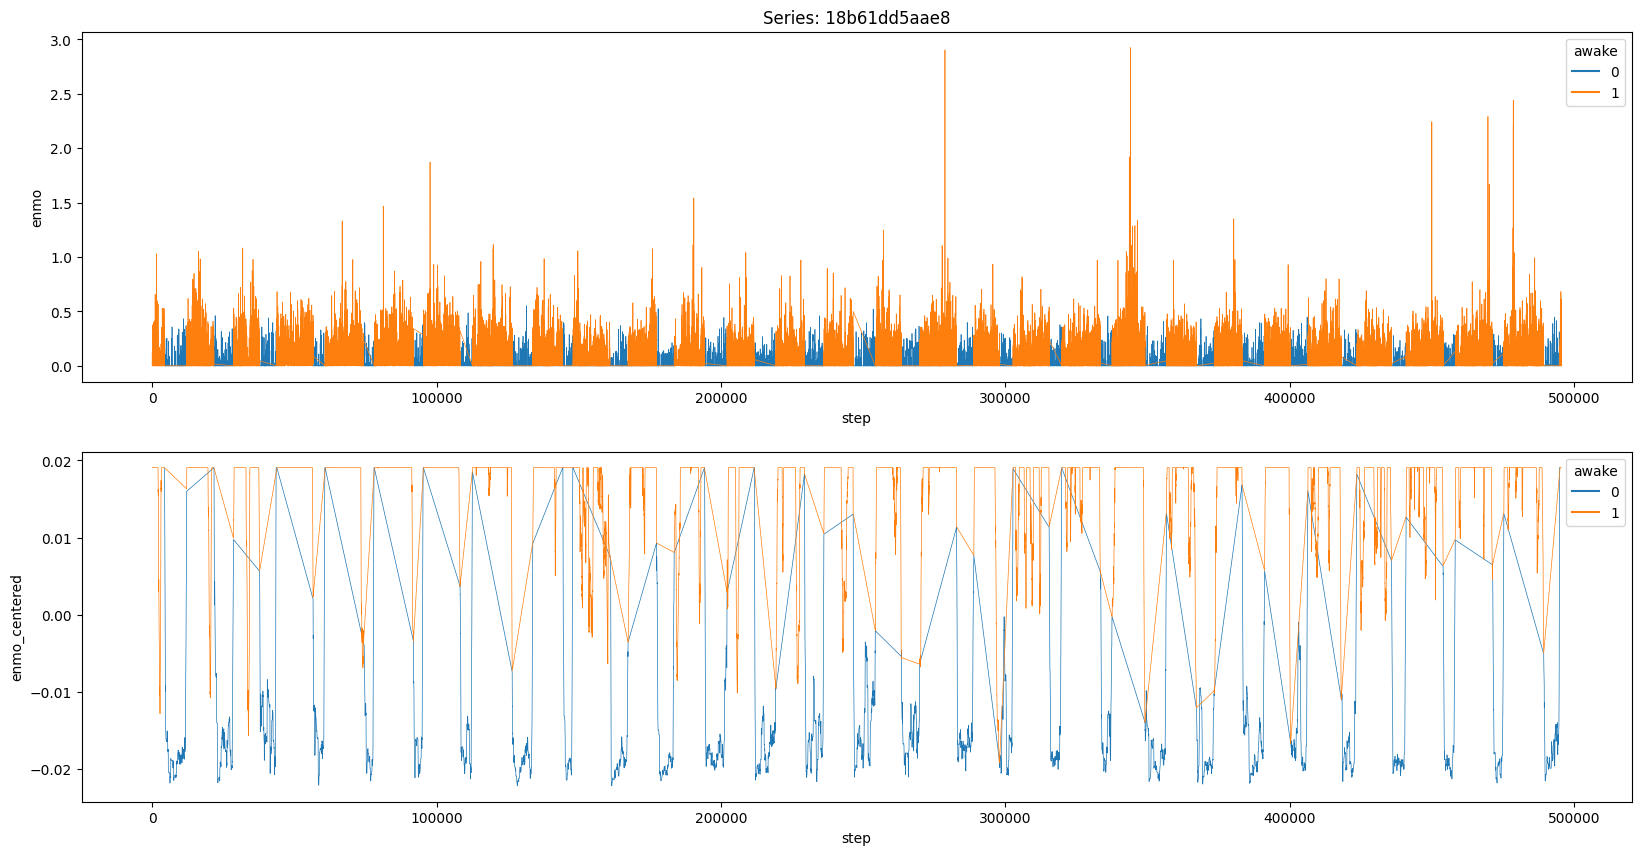

In [212]:
plt.subplots(figsize=(20, 10))

# plot enmo
plt.subplot(2, 1, 1)
sns.lineplot(data=data_viz, x="step", y="enmo", hue="awake", linewidth=0.5)

plt.title(f"Series: {id_viz}")

# plot enmo centered
plt.subplot(2, 1, 2)
sns.lineplot(data=data_viz, x="step", y="enmo_centered", hue="awake", linewidth=0.5)

plt.show()

In [26]:
df_prepared = get_features(df_prepared)

In [27]:
df_prepared.head(1)

series_id step                 timestamp   anglez    enmo awake  \
0  08db4255286f    0  2018-11-05T10:00:00-0400 -30.8453  0.0447     1   

   enmo_centered                   datetime  month  hour   moment  anglez_abs  \
0       0.019935  2018-11-05 10:00:00-04:00     11    10  morning     30.8453   

   anglez_diff  enmo_diff  anglez_rolling_mean  enmo_rolling_mean  \
0      -1.7864     0.0141            32.892733           0.062642   

   enmo_x_anglez  enmo_x_anglez_abs  weekday  is_weekend  
0      -1.378785           1.378785        0           0

With another function from utils.py we created new features: <br>
- datetime, month, hour, moment, weekday and is_weekend from timestamp<br>
- anglez_abs, anglez_diff, anglez_rolling_mean from anglez<br>
- enmo_diff, enmo_rolling_mean from enmo<br>
- enmo_x_aglez, enmo_x_anglez_abs<br>
is_weekend is binary, moment is categorical

### Visualization of new features

In [28]:
columns_to_plot = ['anglez', 'anglez_abs', 'anglez_diff', 'anglez_rolling_mean', \
                   'enmo', 'enmo_centered', 'enmo_diff', 'enmo_rolling_mean',\
                   'enmo_x_anglez', 'enmo_x_anglez_abs',\
                   'month', 'hour', 'moment', 'weekday', 'is_weekend']

In [223]:
# select series for vizualization
id_viz = list_no_na[7]
data_viz = get_series(df_prepared, id_viz)

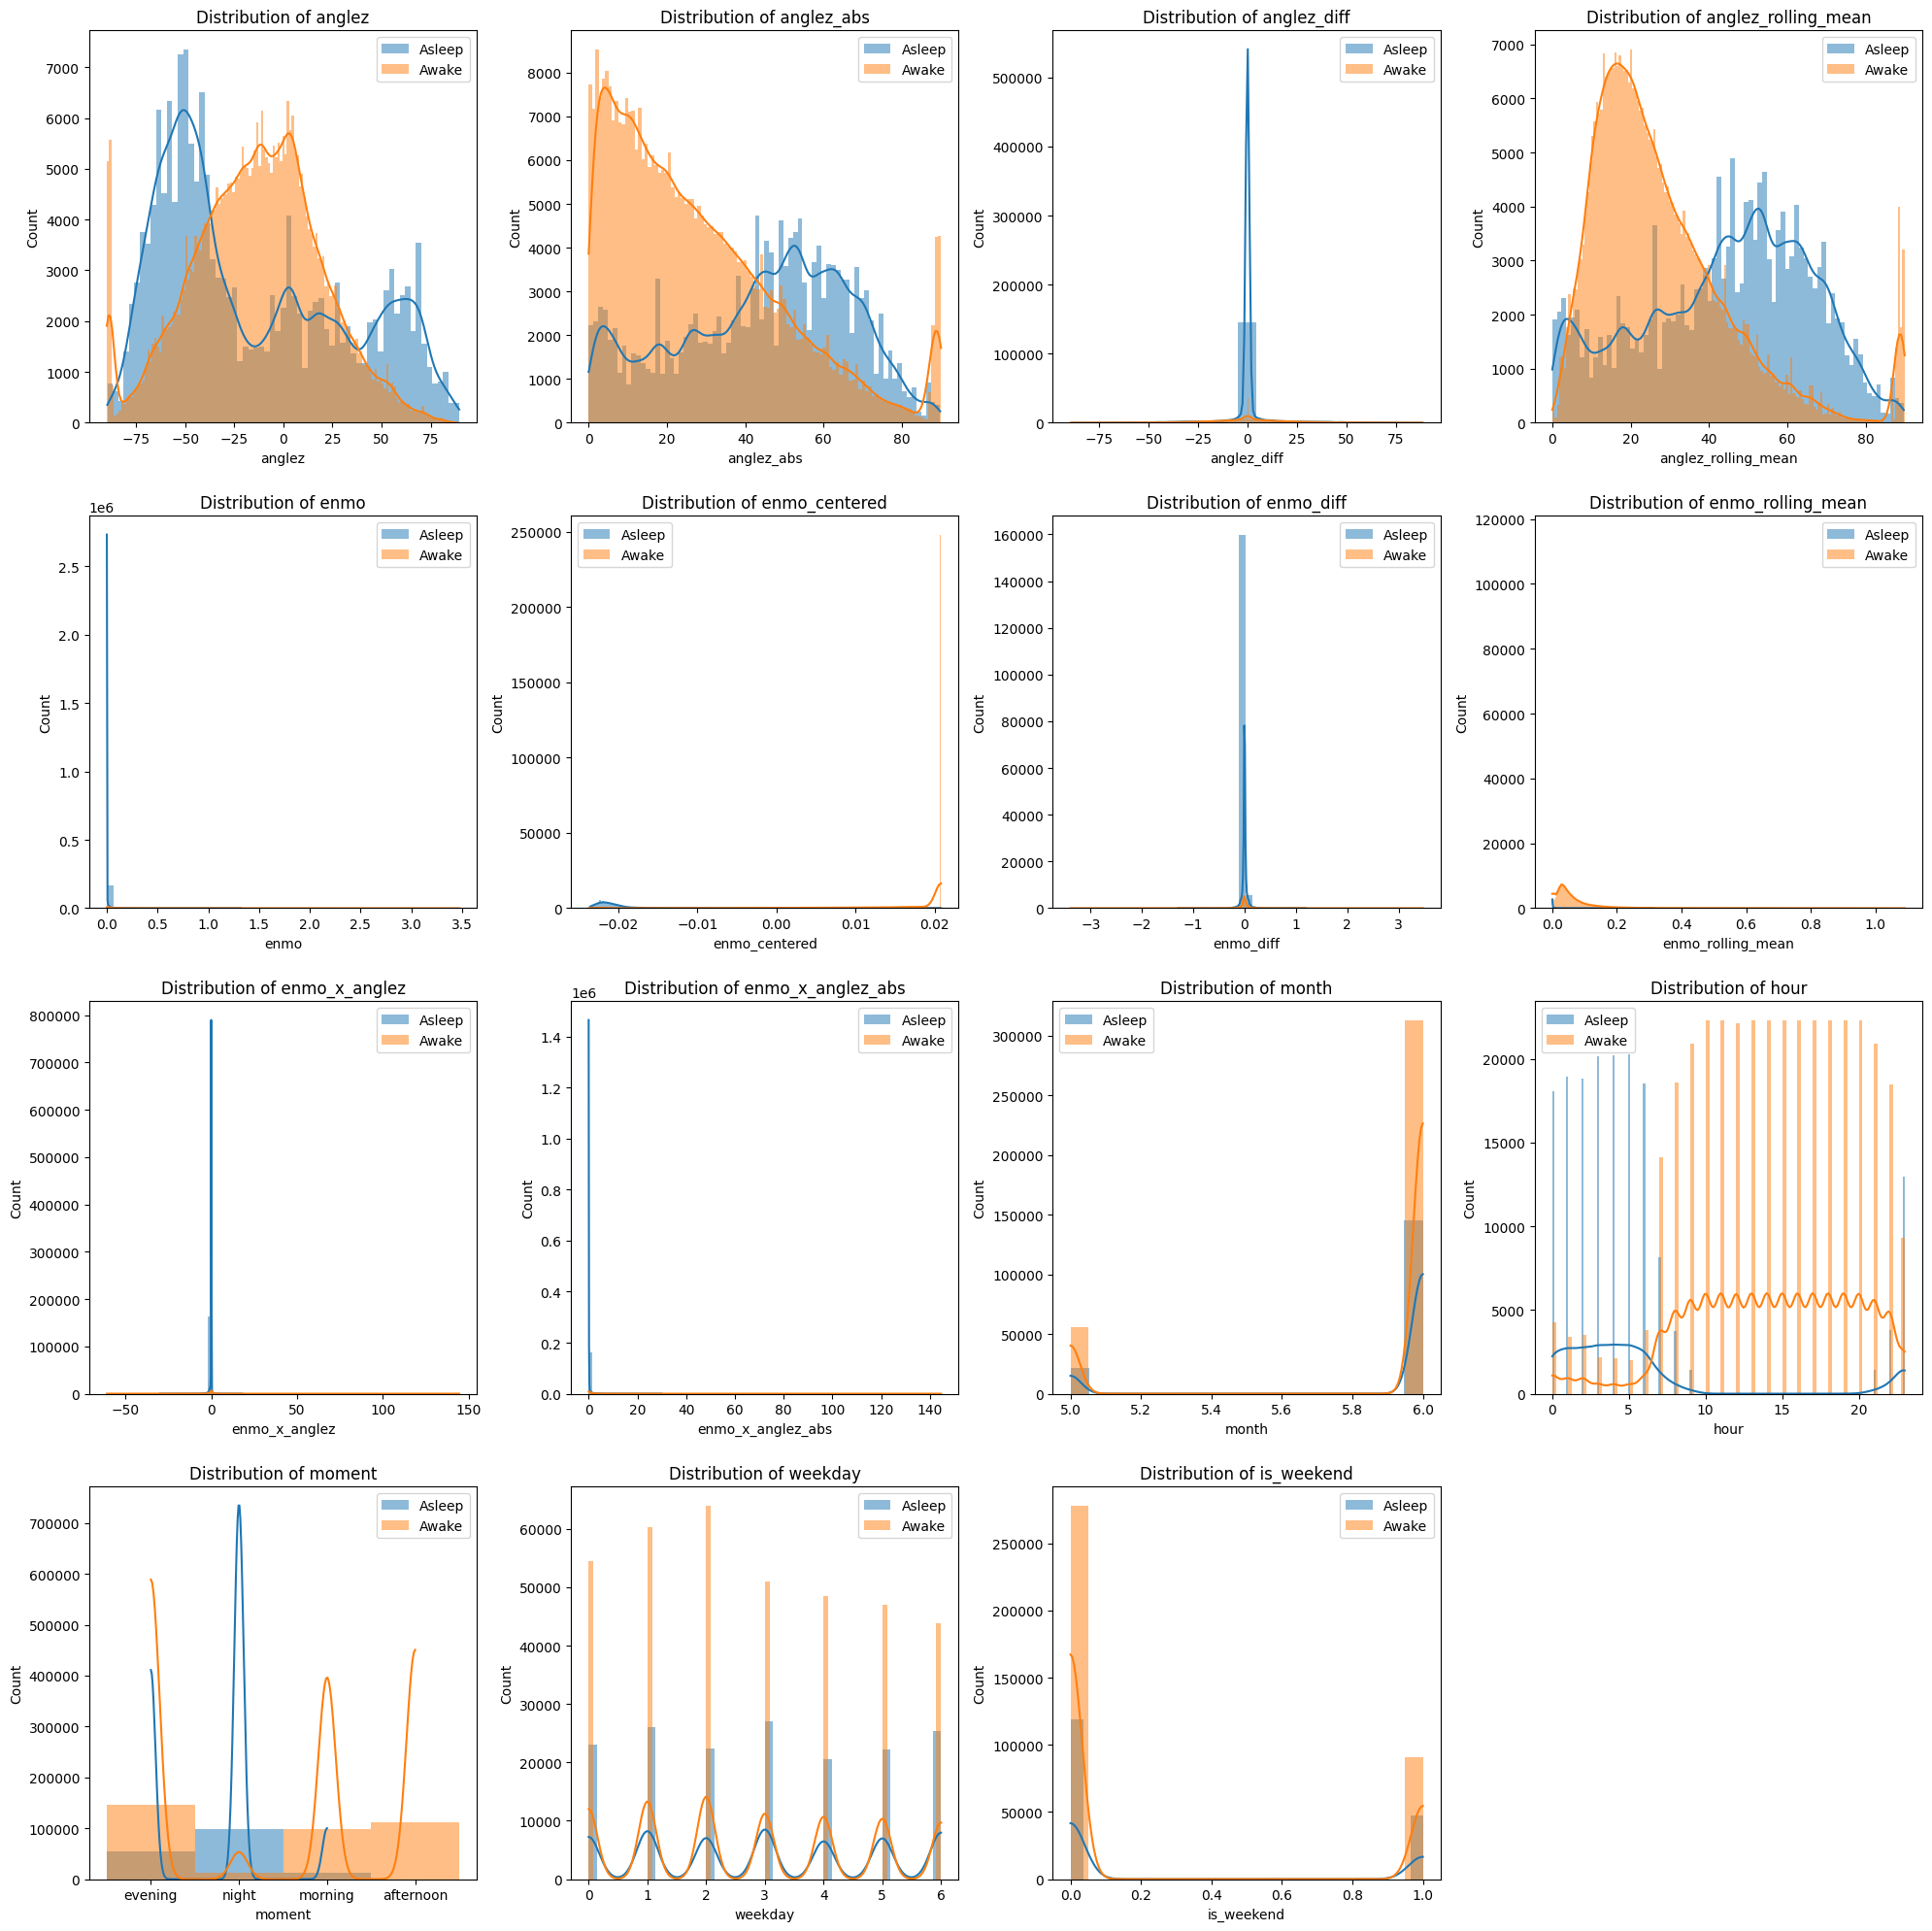

In [224]:
plt.figure(figsize=(20, 20))

for i, column in enumerate(columns_to_plot): # select all columns names minus target
    plt.subplot(4, 4, i+1)
    sns.histplot(data_viz[data_viz["awake"] == 0][column], label="Asleep", linewidth=0, kde=True)
    sns.histplot(data_viz[data_viz["awake"] == 1][column], label="Awake", linewidth=0, kde=True)
    plt.legend()
    plt.title(f"Distribution of {column}")

plt.tight_layout()

plt.show()

<Figure size 640x480 with 0 Axes>

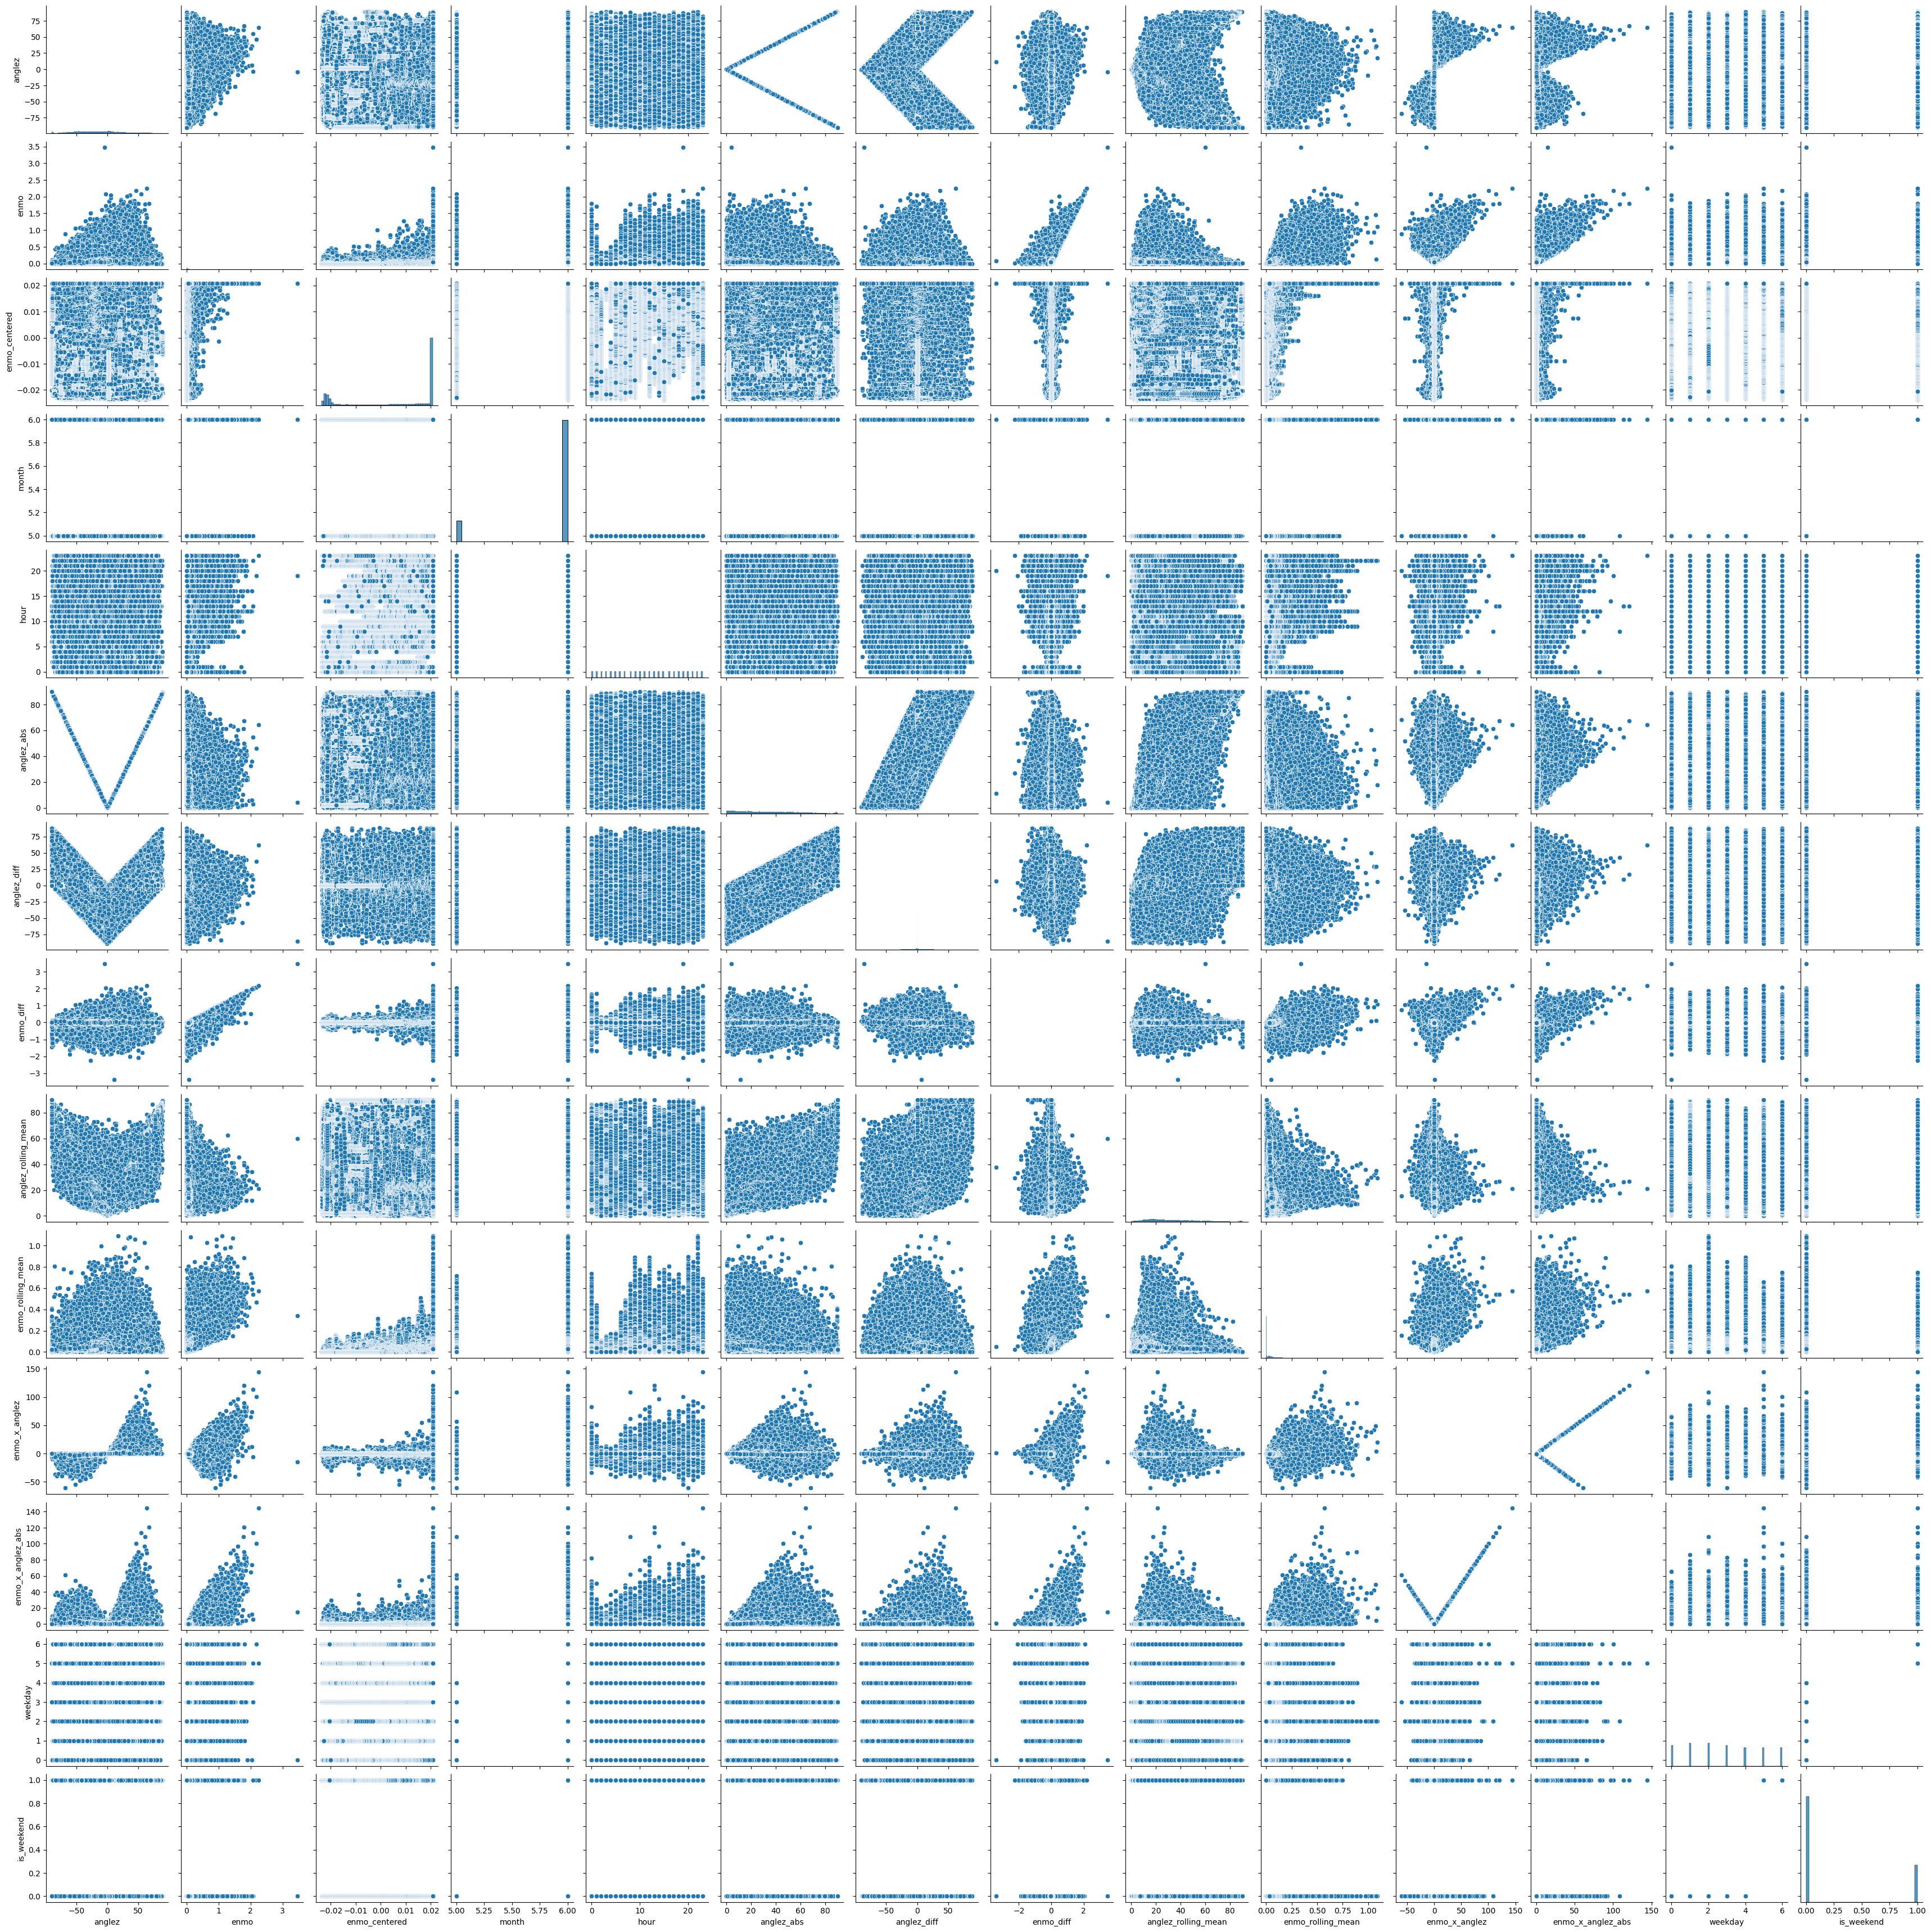

In [221]:
plt.figure()

sns.pairplot(data_viz[columns_to_plot])

plt.show()

In [29]:
df_prepared = df_prepared.drop(columns=["datetime", "month", "weekday"])

### Save prepared dataset

In [30]:
# save dataset 5 series at a time
data_features_1 = df_prepared[df_prepared["series_id"].isin(list_no_na[:5])]
fp_features_1 = os.path.join("..", "output", "data_features_1.csv")
data_features_1.to_csv(fp_features_1)

## III- Preprocessing

### Split train and test

For the train set we will use the 10 first series, and the ten others for the test set.

In [5]:
fp_features_1 = os.path.join("..", "output", "with_features", "data_features_1.csv")
data_features_1 = pd.read_csv(fp_features_1)

fp_features_2 = os.path.join("..", "output", "with_features", "data_features_2.csv")
data_features_2 = pd.read_csv(fp_features_2)

fp_features_3 = os.path.join("..", "output", "with_features", "data_features_3.csv")
data_features_3 = pd.read_csv(fp_features_3)

fp_features_4 = os.path.join("..", "output", "with_features", "data_features_4.csv")
data_features_4 = pd.read_csv(fp_features_4)

In [6]:
data_train = pd.concat([data_features_1, data_features_2])
data_train = data_train.drop(columns="Unnamed: 0")
data_train = data_train.reset_index(drop=True)

In [8]:
data_test = pd.concat([data_features_3, data_features_4])
data_test = data_test.drop(columns="Unnamed: 0")
data_test = data_test.reset_index(drop=True)

In [10]:
data_train.shape, data_test.shape

((3417480, 17), (3868020, 17))

In [18]:
cols_to_train = ['anglez', 'enmo', 'enmo_centered', 'hour', 'moment',\
                 'anglez_abs', 'anglez_diff', 'enmo_diff', 'anglez_rolling_mean', 'enmo_rolling_mean',\
                 'enmo_x_anglez', 'enmo_x_anglez_abs', 'is_weekend']

In [15]:
X_train = data_train[cols_to_train]
y_train = data_train["awake"]

X_test = data_test[cols_to_train]
y_test = data_test["awake"]

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3417480, 13), (3868020, 13), (3417480,), (3868020,))

### Column Transformer

We are going to create a preprocessing pipeling for scaling and one hot encoding.

In [13]:
categorical_features = ["moment"]
numeric_features = ['anglez', 'enmo', 'hour', 'anglez_abs', 'anglez_diff',\
                   'enmo_diff', 'anglez_rolling_mean', 'enmo_rolling_mean', 'enmo_x_anglez', 'enmo_x_anglez_abs']
other_features = ["enmo_centered", "is_weekend"]

In [23]:
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder()),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
        ("other", "passthrough", other_features)
    ]
)

## IV- Model

Previous experiments with various models showed that XGBoost Classifier had the best results

### Simple XGBoost Classifier

In [35]:
final_steps = [('prepross', preprocessor), 
               ('xgb', xgb.XGBClassifier(enable_categorical=True))]

In [36]:
pipe = Pipeline(final_steps)

In [37]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('prepross',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['anglez', 'enmo', 'hour',
                                                   'anglez_abs', 'anglez_diff',
                                                   'enmo_diff',
                                                   'anglez_rolling_mean',
                                                   'enmo_rolling_mean',
                                                   'enmo_x_anglez',
                                                   'enmo_x_anglez_abs']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['moment']),
                                                 ('other', 'passthrough',
                                                  ['enmo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [38]:
pipe.score(X_train,y_train)

0.9803753057808677

In [39]:
pipe.score(X_test,y_test)

0.9514526812167465

### GridSearch

In [43]:
param_dist = {
    "xgb__n_estimators": [50, 100, 200],
    "xgb__max_depth": [3, 6, 9],
    "xgb__learning_rate": [0.01, 0.05, 0.1]
}

In [44]:
grid = GridSearchCV(pipe, param_dist, cv=3, scoring='f1_micro')

In [45]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prepross',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['anglez',
                                                                          'enmo',
                                                                          'hour',
                                                                          'anglez_abs',
                                                                          'anglez_diff',
                                                                          'enmo_diff',
                                                                          'anglez_rolling_mean',
                                                                          'enmo_rolling_mean',
                                                                          'enmo_x_anglez',
                                                                          'enmo_x_anglez_abs']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder())]),
                                                                         ['moment']),
                                                                        (...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 6, 9],
                         'xgb__n_estimators': [50, 100, 200]},
             scoring='f1_micro')

In [46]:
grid.score(X_train, y_train)

0.9659939487575641

In [48]:
grid.score(X_test, y_test)

0.9533901065661501

In [49]:
grid.best_params_

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}

### Save pipeline

In [61]:
fp_pipeline = os.path.join("..", "trained_models", "pipeline_01.pkl")
pickle.dump(grid.best_estimator_, open(fp_pipeline, 'wb'))

In [51]:
grid.best_estimator_.predict(X_test)

array([1, 1, 1, ..., 0, 0, 0])

In [52]:
grid.best_estimator_.predict_proba(X_test)

array([[0.0012694 , 0.9987306 ],
       [0.00118446, 0.99881554],
       [0.00101739, 0.9989826 ],
       ...,
       [0.9467792 , 0.05322083],
       [0.9467792 , 0.05322083],
       [0.9467792 , 0.05322083]], dtype=float32)

## V- Predictions

In [4]:
# Load pipeline
fp_pipeline = os.path.join("..", "trained_models", "pipeline_01.pkl")
pipeline_1 = pickle.load(open(fp_pipeline, 'rb'))

In [173]:
# predict X_test
#y_pred = grid.best_estimator_.predict(X_test)
y_pred = pipeline_1.predict(X_test)

In [174]:
# get probas
#probas = grid.best_estimator_.predict_proba(X_test)
probas = pipeline_1.predict_proba(X_test)
y_probas = [max(proba) for proba in probas]

In [175]:
print("Accuracy score:", accuracy_score(y_test, y_pred))
print("F1 score", f1_score(y_test, y_pred))
print("Classiffication report:\n", classification_report(y_test, y_pred))

Accuracy score: 0.9533901065661501
F1 score 0.9639672625888138
Classiffication report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93   1394940
           1       0.95      0.98      0.96   2473080

    accuracy                           0.95   3868020
   macro avg       0.95      0.94      0.95   3868020
weighted avg       0.95      0.95      0.95   3868020



This is the result for a classification problem where we want to predict whether a person is asleep or awake.<br>
But our original goal is to predict events (onset and wakeup) over time.<br>
Let's look at the sample_submission provided by kaggle.

In [83]:
fp_example = os.path.join("..", "input", "sample_submission.csv")
sample_submission = pd.read_csv(fp_example)
sample_submission.head(5)

row_id     series_id  step   event  score
0       0  038441c925bb   100   onset    0.0
1       1  038441c925bb   105  wakeup    0.0
2       2  03d92c9f6f8a    80   onset    0.5
3       3  03d92c9f6f8a   110  wakeup    0.5
4       4  0402a003dae9    90   onset    1.0

So we need to create:<br>
- a column event with "onset" or "wakeup"<br>
- a column score<br>
- a column row_id<br>
Additionally we need to make sure that every period of sleep starts and ends 

For this we use funtions in utils.py:<br>
- smooth_results which applies a rolling mean on the predictions<br>
- get_events which selects the rows corresponding to events<br>
- get_subbmission which returns a dataframe with only required columns for submission<br>
- keep_periods which select periods of sleep > given time

In [176]:
# smooth predictions
y_smooth = smooth_results(data_test, y_pred, 1000)
# get events corresponding to predictions
df_events = get_events(data_test, y_smooth, y_probas)
# create submission dataFrame
df_submission = get_submission(df_events)
# keep_periods > 1h
df_submission = keep_periods(df_submission, 12*60*1)

delete onset
delete onset
delete onset
delete onset
delete onset
delete onset


### Visualization of predictions

In [177]:
# select a series for visualization
list_id = data_test["series_id"].unique()
id_viz = list_id[3]
df_viz = get_series(data_test, id_viz)
df_pred = get_series(df_submission, id_viz)

In [178]:
onset_viz = df_pred[df_pred["event"] == "onset"]
wakeup_viz = df_pred[df_pred["event"] == "wakeup"]

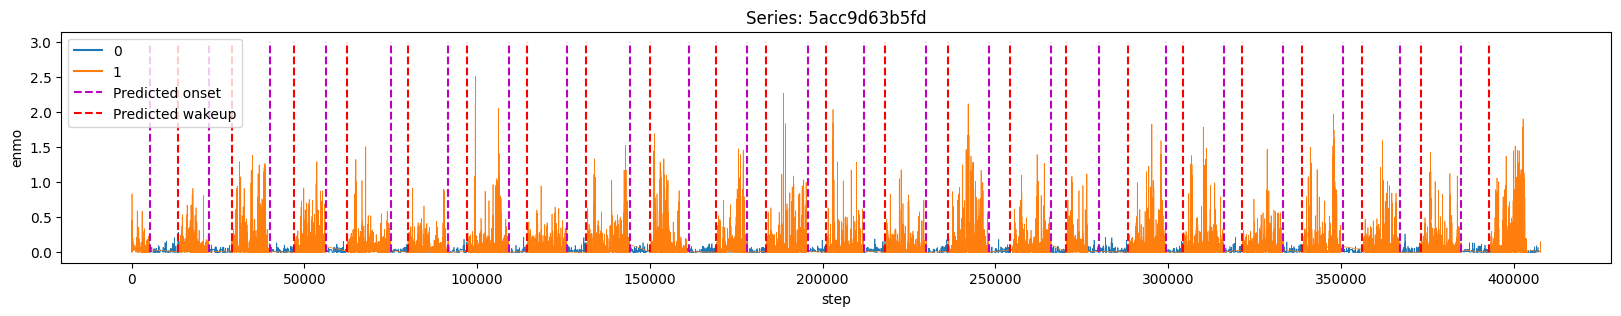

In [179]:
plt.figure(figsize=(20, 3))

# plot enmo
sns.lineplot(data=df_viz, x="step", y="enmo", hue="awake", linewidth=0.5)
    
# plot events onset
plt.vlines(x=onset_viz["step"].values, ymin=0, ymax=3, colors = 'm', label = "Predicted onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_viz["step"].values, ymin=0, ymax=3, colors = 'r', label = "Predicted wakeup", linestyles="dashed")
    
plt.legend()

plt.title(f"Series: {id_viz}")

plt.show()

## VI- Evaluation

Now we're going to use the metric used in the competition: average precision of detected events.<br>
The metric is averaged over timestamp error tolerance thresholds then averaged over event classes.

"Detections are matched to ground-truth events within error tolerances, with ambiguities resolved in order of decreasing confidence. For both event classes, we use error tolerance thresholds of 1, 3, 5, 7.5, 10, 12.5, 15, 20, 25, 30 in minutes, or 12, 36, 60, 90, 120, 150, 180, 240, 300, 360 in steps."

The following cell shows you the code provided on Event Detection AP notebook:<br>
(https://www.kaggle.com/code/metric/event-detection-ap/notebook)

In [6]:
"""Event Detection Average Precision

An average precision metric for event detection in time series and
video.

"""

import numpy as np
import pandas as pd
import pandas.api.types
from typing import Dict, List, Tuple


class ParticipantVisibleError(Exception):
    pass


# Set some placeholders for global parameters
series_id_column_name = None
time_column_name = None
event_column_name = None
score_column_name = None
use_scoring_intervals = None


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
        series_id_column_name: str,
        time_column_name: str,
        event_column_name: str,
        score_column_name: str,
        use_scoring_intervals: bool = False,
) -> float:
    """Event Detection Average Precision, an AUCPR metric for event detection in
    time series and video.

    This metric is similar to IOU-threshold average precision metrics commonly
    used in object detection. For events occuring in time series, we replace the
    IOU threshold with a time tolerance.

    Submissions are evaluated on the average precision of detected events,
    averaged over timestamp error tolerance thresholds, averaged over event
    classes.

    Detections are matched to ground-truth events within error tolerances, with
    ambiguities resolved in order of decreasing confidence.

    Detailed Description
    --------------------
    Evaluation proceeds in four steps:

    1. Selection - (optional) Predictions not within a series' scoring
    intervals are dropped.
    2. Assignment - Predicted events are matched with ground-truth events.
    3. Scoring - Each group of predictions is scored against its corresponding
    group of ground-truth events via Average Precision.
    4. Reduction - The multiple AP scores are averaged to produce a single
    overall score.

    Selection

    With each series there may be a defined set of scoring intervals giving the
    intervals of time over which zero or more ground-truth events might be
    annotated in that series. A prediction will be evaluated only if it falls
    within a scoring interval. These scoring intervals can be chosen to improve
    the fairness of evaluation by, for instance, ignoring edge-cases or
    ambiguous events.

    It is recommended that, if used, scoring intervals be provided for training
    data but not test data.

    Assignment

    For each set of predictions and ground-truths within the same `event x
    tolerance x series_id` group, we match each ground-truth to the
    highest-confidence unmatched prediction occurring within the allowed
    tolerance.

    Some ground-truths may not be matched to a prediction and some predictions
    may not be matched to a ground-truth. They will still be accounted for in
    the scoring, however.

    Scoring

    Collecting the events within each `series_id`, we compute an Average
    Precision score for each `event x tolerance` group. The average precision
    score is the area under the (step-wise) precision-recall curve generated by
    decreasing confidence score thresholds over the predictions. In this
    calculation, matched predictions over the threshold are scored as TP and
    unmatched predictions as FP. Unmatched ground-truths are scored as FN.

    Reduction

    The final score is the average of the above AP scores, first averaged over
    tolerance, then over event.

    Parameters
    ----------
    solution : pd.DataFrame, with columns:

        `series_id_column_name` identifier for each time series

        `time_column_name` the time of occurence for each event as a numeric type

        `event_column_name` class label for each event

        The solution contains the time of occurence of one or more types of
        event within one or more time series. The metric expects the solution to
        contain the same event types as those given in `tolerances`.

        When `use_scoring_intervals == True`, you may include `start` and `end`
        events to delimit intervals within which detections will be scored.
        Detected events (from the user submission) outside of these events will
        be ignored.

    submission : pd.DataFrame, with columns as above and in addition:

        `score_column_name` the predicted confidence score for the detected event

    tolerances : Dict[str, List[float]]

        Maps each event class to a list of timestamp tolerances used
        for matching detections to ground-truth events.

    use_scoring_intervals: bool, default False

        Whether to ignore predicted events outside intervals delimited
        by `'start'` and `'end'` events in the solution. When `False`,
        the solution should not include `'start'` and `'end'` events.
        See the examples for illustration.

    Returns
    -------
    event_detection_ap : float
        The mean average precision of the detected events.

    Examples
    --------
    Detecting `'pass'` events in football:
    >>> column_names = {
    ...     'series_id_column_name': 'video_id',
    ...     'time_column_name': 'time',
    ...     'event_column_name': 'event',
    ...     'score_column_name': 'score',
    ... }
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a'],
    ...     'event': ['pass', 'pass'],
    ...     'time': [0, 15],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 10, 14.5],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    Increasing the confidence score of the false detection above the true
    detections decreases the AP.
    >>> submission.loc[1, 'score'] = 1.5
    >>> score(solution, submission, tolerances, **column_names)
    0.6666666666666666...

    Likewise, decreasing the confidence score of a true detection below the
    false detection also decreases the AP.
    >>> submission.loc[1, 'score'] = 0.5  # reset
    >>> submission.loc[0, 'score'] = 0.0
    >>> score(solution, submission, tolerances, **column_names)
    0.8333333333333333...

    We average AP scores over tolerances. Previously, the detection at 14.5
    would match, but adding smaller tolerances gives AP scores where it does
    not match. This results in both a FN, since the ground-truth wasn't
    detected, and a FP, since the detected event matches no ground-truth.
    >>> tolerances = {'pass': [0.1, 0.2, 1.0]}
    >>> score(solution, submission, tolerances, **column_names)
    0.3888888888888888...

    We also average over time series and over event classes.
    >>> tolerances = {'pass': [0.5, 1.0], 'challenge': [0.25, 0.50]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'time': [0, 15, 0],  # restart time for new time series b
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'b'],
    ...     'event': ['pass', 'challenge', 'pass'],
    ...     'score': [1.0, 0.5, 1.0],
    ...     'time': [0, 15, 0],
    ... })
    >>> score(solution, submission, tolerances, **column_names)
    1.0

    By adding scoring intervals to the solution, we may choose to ignore
    detections outside of those intervals.
    >>> tolerances = {'pass': [1.0]}
    >>> solution = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a', 'a'],
    ...     'event': ['start', 'pass', 'pass', 'end'],
    ...     'time': [0, 10, 20, 30],
    ... })
    >>> submission = pd.DataFrame({
    ...     'video_id': ['a', 'a', 'a'],
    ...     'event': ['pass', 'pass', 'pass'],
    ...     'score': [1.0, 1.0, 1.0],
    ...     'time': [10, 20, 40],
    ... })
    >>> score(solution, submission, tolerances, **column_names, use_scoring_intervals=True)
    1.0

    """
    # Validate metric parameters
    assert len(tolerances) > 0, "Events must have defined tolerances."
    assert set(tolerances.keys()) == set(solution[event_column_name]).difference({'start', 'end'}),\
        (f"Solution column {event_column_name} must contain the same events "
         "as defined in tolerances.")
    assert pd.api.types.is_numeric_dtype(solution[time_column_name]),\
        f"Solution column {time_column_name} must be of numeric type."

    # Validate submission format
    for column_name in [
        series_id_column_name,
        time_column_name,
        event_column_name,
        score_column_name,
    ]:
        if column_name not in submission.columns:
            raise ParticipantVisibleError(f"Submission must have column '{target_name}'.")

    if not pd.api.types.is_numeric_dtype(submission[time_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{time_column_name}' must be of numeric type."
        )
    if not pd.api.types.is_numeric_dtype(submission[score_column_name]):
        raise ParticipantVisibleError(
            f"Submission column '{score_column_name}' must be of numeric type."
        )

    # Set these globally to avoid passing around a bunch of arguments
    globals()['series_id_column_name'] = series_id_column_name
    globals()['time_column_name'] = time_column_name
    globals()['event_column_name'] = event_column_name
    globals()['score_column_name'] = score_column_name
    globals()['use_scoring_intervals'] = use_scoring_intervals

    return event_detection_ap(solution, submission, tolerances)


def filter_detections(
        detections: pd.DataFrame, intervals: pd.DataFrame
) -> pd.DataFrame:
    """Drop detections not inside a scoring interval."""
    detection_time = detections.loc[:, time_column_name].sort_values().to_numpy()
    intervals = intervals.to_numpy()
    is_scored = np.full_like(detection_time, False, dtype=bool)

    i, j = 0, 0
    while i < len(detection_time) and j < len(intervals):
        time = detection_time[i]
        int_ = intervals[j]

        # If the detection is prior in time to the interval, go to the next detection.
        if time < int_.left:
            i += 1
        # If the detection is inside the interval, keep it and go to the next detection.
        elif time in int_:
            is_scored[i] = True
            i += 1
        # If the detection is later in time, go to the next interval.
        else:
            j += 1

    return detections.loc[is_scored].reset_index(drop=True)


def match_detections(
        tolerance: float, ground_truths: pd.DataFrame, detections: pd.DataFrame
) -> pd.DataFrame:
    """Match detections to ground truth events. Arguments are taken from a common event x tolerance x series_id evaluation group."""
    detections_sorted = detections.sort_values(score_column_name, ascending=False).dropna()
    is_matched = np.full_like(detections_sorted[event_column_name], False, dtype=bool)
    gts_matched = set()
    for i, det in enumerate(detections_sorted.itertuples(index=False)):
        best_error = tolerance
        best_gt = None

        for gt in ground_truths.itertuples(index=False):
            error = abs(getattr(det, time_column_name) - getattr(gt, time_column_name))
            if error < best_error and gt not in gts_matched:
                best_gt = gt
                best_error = error

        if best_gt is not None:
            is_matched[i] = True
            gts_matched.add(best_gt)

    detections_sorted['matched'] = is_matched

    return detections_sorted


def precision_recall_curve(
        matches: np.ndarray, scores: np.ndarray, p: int
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    if len(matches) == 0:
        return [1], [0], []

    # Sort matches by decreasing confidence
    idxs = np.argsort(scores, kind='stable')[::-1]
    scores = scores[idxs]
    matches = matches[idxs]

    distinct_value_indices = np.where(np.diff(scores))[0]
    threshold_idxs = np.r_[distinct_value_indices, matches.size - 1]
    thresholds = scores[threshold_idxs]

    # Matches become TPs and non-matches FPs as confidence threshold decreases
    tps = np.cumsum(matches)[threshold_idxs]
    fps = np.cumsum(~matches)[threshold_idxs]

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    recall = tps / p  # total number of ground truths might be different than total number of matches

    # Stop when full recall attained and reverse the outputs so recall is non-increasing.
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)

    # Final precision is 1 and final recall is 0
    return np.r_[precision[sl], 1], np.r_[recall[sl], 0], thresholds[sl]


def average_precision_score(matches: np.ndarray, scores: np.ndarray, p: int) -> float:
    precision, recall, _ = precision_recall_curve(matches, scores, p)
    # Compute step integral
    return -np.sum(np.diff(recall) * np.array(precision)[:-1])


def event_detection_ap(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        tolerances: Dict[str, List[float]],
) -> float:

    # Ensure solution and submission are sorted properly
    solution = solution.sort_values([series_id_column_name, time_column_name])
    submission = submission.sort_values([series_id_column_name, time_column_name])

    # Extract scoring intervals.
    if use_scoring_intervals:
        intervals = (
            solution
            .query("event in ['start', 'end']")
            .assign(interval=lambda x: x.groupby([series_id_column_name, event_column_name]).cumcount())
            .pivot(
                index='interval',
                columns=[series_id_column_name, event_column_name],
                values=time_column_name,
            )
            .stack(series_id_column_name)
            .swaplevel()
            .sort_index()
            .loc[:, ['start', 'end']]
            .apply(lambda x: pd.Interval(*x, closed='both'), axis=1)
        )

    # Extract ground-truth events.
    ground_truths = (
        solution
        .query("event not in ['start', 'end']")
        .reset_index(drop=True)
    )

    # Map each event class to its prevalence (needed for recall calculation)
    class_counts = ground_truths.value_counts(event_column_name).to_dict()

    # Create table for detections with a column indicating a match to a ground-truth event
    detections = submission.assign(matched = False)

    # Remove detections outside of scoring intervals
    if use_scoring_intervals:
        detections_filtered = []
        for (det_group, dets), (int_group, ints) in zip(
            detections.groupby(series_id_column_name), intervals.groupby(series_id_column_name)
        ):
            assert det_group == int_group
            detections_filtered.append(filter_detections(dets, ints))
        detections_filtered = pd.concat(detections_filtered, ignore_index=True)
    else:
        detections_filtered = detections

    # Create table of event-class x tolerance x series_id values
    aggregation_keys = pd.DataFrame(
        [(ev, tol, vid)
         for ev in tolerances.keys()
         for tol in tolerances[ev]
         for vid in ground_truths[series_id_column_name].unique()],
        columns=[event_column_name, 'tolerance', series_id_column_name],
    )

    # Create match evaluation groups: event-class x tolerance x series_id
    detections_grouped = (
        aggregation_keys
        .merge(detections_filtered, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    ground_truths_grouped = (
        aggregation_keys
        .merge(ground_truths, on=[event_column_name, series_id_column_name], how='left')
        .groupby([event_column_name, 'tolerance', series_id_column_name])
    )
    # Match detections to ground truth events by evaluation group
    detections_matched = []
    for key in aggregation_keys.itertuples(index=False):
        dets = detections_grouped.get_group(key)
        gts = ground_truths_grouped.get_group(key)
        detections_matched.append(
            match_detections(dets['tolerance'].iloc[0], gts, dets)
        )
    detections_matched = pd.concat(detections_matched)

    # Compute AP per event x tolerance group
    event_classes = ground_truths[event_column_name].unique()
    ap_table = (
        detections_matched
        .query("event in @event_classes")
        .groupby([event_column_name, 'tolerance']).apply(
            lambda group: average_precision_score(
                group['matched'].to_numpy(),
                group[score_column_name].to_numpy(),
                class_counts[group[event_column_name].iat[0]],
            )
        )
    )
    # Average over tolerances, then over event classes
    mean_ap = ap_table.groupby(event_column_name).mean().sum() / len(event_classes)

    return mean_ap

We set the tolerances according to the competition rules and the columns variable names according to our dataframe:

In [7]:
import pandas.api.types
from typing import Dict, List, Tuple

# tolerances in steps
tolerances = {
    "onset":  [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
}

series_id_column_name = "series_id"
time_column_name = "step"
event_column_name = "event"
score_column_name = "score"
use_scoring_intervals = None

We then need to select the series corresponding to our test set in train_events.csv.<br>
We have loaded it in data_events at the beginning of the notebook.

In [180]:
data_eval = data_events[data_events["series_id"].isin(list_id)]

And we apply the metric:

In [181]:
event_detection_ap(data_eval, df_submission, tolerances)

0.3031046722372638

The results are much lower than previously!<br>
Let's take a closer look at our predictions.

In [182]:
# select a series for visualization
list_id = data_test["series_id"].unique()
id_viz = list_id[3]
df_viz = get_series(data_test, id_viz)
df_pred = get_series(df_submission, id_viz)

In [183]:
onset_viz = df_pred[df_pred["event"] == "onset"]
wakeup_viz = df_pred[df_pred["event"] == "wakeup"]

In [184]:
# select a fragment of series
start_id = 108000
end_id = 115000
data_zoom = df_viz[start_id: end_id]
event_zoom = df_pred[df_pred["step"].isin(data_zoom["step"])]
onset_zoom = event_zoom[event_zoom["event"] == "onset"]
wakeup_zoom = event_zoom[event_zoom["event"] == "wakeup"]

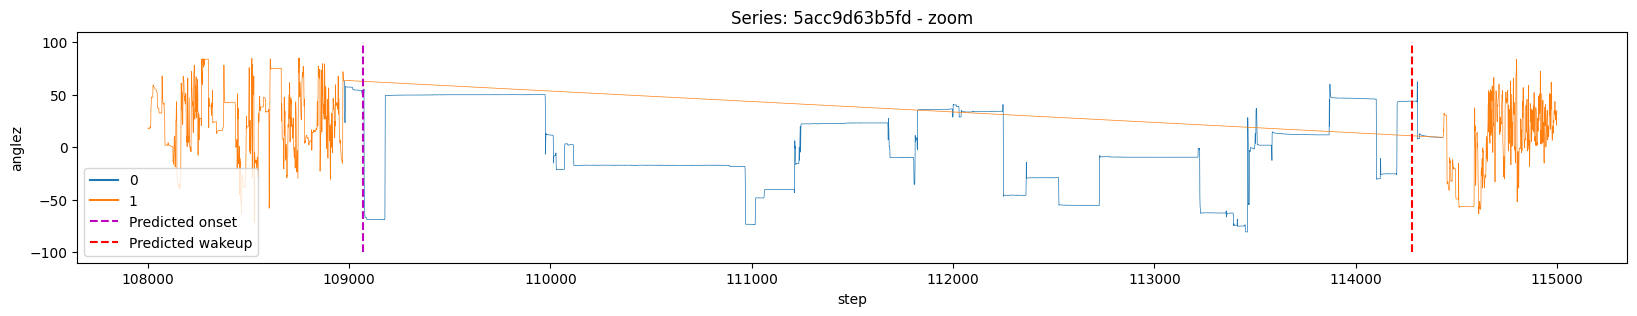

In [185]:
plt.figure(figsize=(20, 3))

# plot enmo
sns.lineplot(data=data_zoom, x="step", y="anglez", hue="awake", linewidth=0.5)
    
# plot events onset
plt.vlines(x=onset_zoom["step"].values, ymin=-100, ymax=100, colors = 'm', label = "Predicted onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_zoom["step"].values, ymin=-100, ymax=100, colors = 'r', label = "Predicted wakeup", linestyles="dashed")
    
plt.legend()

plt.title(f"Series: {id_viz} - zoom")

plt.show()

The predicted events are roughlt 100 steps away from the truth, this is why the score is low.

## VII- Submission

### Load test set for submission

In [8]:
filepath = os.path.join("..", "input", "test_series.parquet")
data = pd.read_parquet(filepath)
data.head(3)

series_id  step                 timestamp  anglez    enmo
0  038441c925bb     0  2018-08-14T15:30:00-0400  2.6367  0.0217
1  038441c925bb     1  2018-08-14T15:30:05-0400  2.6368  0.0215
2  038441c925bb     2  2018-08-14T15:30:10-0400  2.6370  0.0216

In [9]:
data.shape

(450, 5)

In [10]:
list_id = data["series_id"].unique()

In [11]:
print("Number of series:", len(list_id))
print(f"Average lenght of series: {data.shape[0] / 12 / len(list_id)} minutes.")

Number of series: 3
Average lenght of series: 12.5 minutes.


3 series of 12.5 minutes

### Feature engineering

In [12]:
print("Average number of rows by series:", data.shape[0] / len(list_id))

Average number of rows by series: 150.0


In [13]:
df_test = preprocess_col(data, "enmo", 15)

In [14]:
df_test = get_features(df_test)

In [15]:
df_test.head(1)

series_id step                 timestamp  anglez    enmo  enmo_centered  \
0  038441c925bb    0  2018-08-14T15:30:00-0400  2.6367  0.0217       0.007679   

                    datetime  month  hour     moment  anglez_abs  anglez_diff  \
0  2018-08-14 15:30:00-04:00      8    15  afternoon      2.6367      -0.2238   

   enmo_diff  anglez_rolling_mean  enmo_rolling_mean  enmo_x_anglez  \
0     0.0001               2.6898           0.021775       0.057216   

   enmo_x_anglez_abs  weekday  is_weekend  
0           0.057216        1           0

In [16]:
df_test = df_test.drop(columns=["datetime", "month", "weekday"])

In [19]:
X_eval = df_test[cols_to_train]

In [20]:
# get prediction
y_pred = pipeline_1.predict(X_eval)

In [21]:
# get probas
probas = pipeline_1.predict_proba(X_eval)
y_probas = [max(proba) for proba in probas]

In [22]:
# smooth predictions
y_smooth = smooth_results(df_test, y_pred, 1000)
# get events corresponding to predictions
df_events = get_events(df_test, y_smooth, y_probas)
# create submission dataFrame
df_submission = get_submission(df_events)
# keep_periods > 1h
df_submission = keep_periods(df_submission, 12*60*1)

In [23]:
# select a series for visualization
list_id = df_test["series_id"].unique()
id_viz = list_id[0]
df_viz = get_series(df_test, id_viz)
df_pred = get_series(df_submission, id_viz)
onset_viz = df_pred[df_pred["event"] == "onset"]
wakeup_viz = df_pred[df_pred["event"] == "wakeup"]

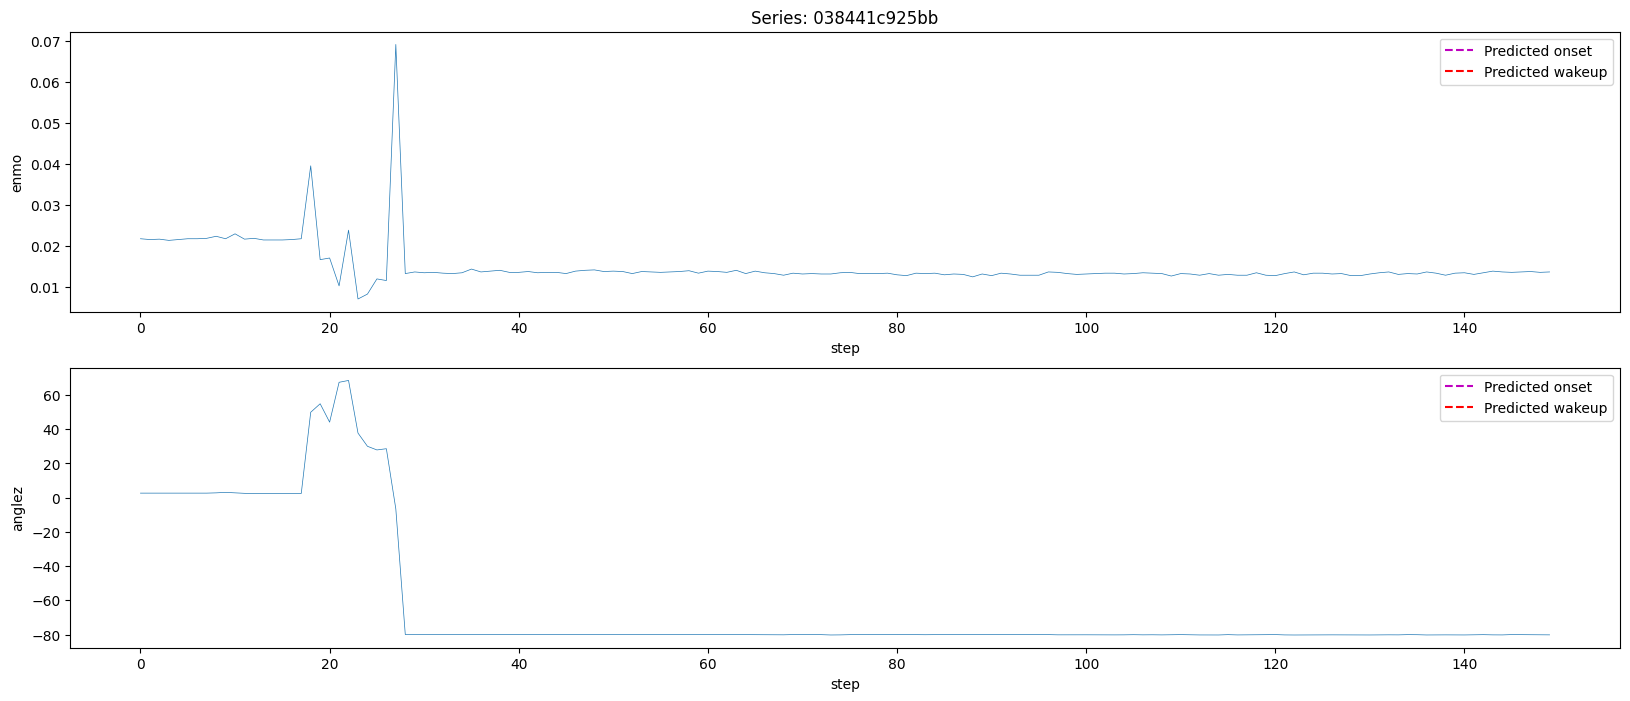

In [24]:
plt.subplots(figsize=(20, 8))

plt.subplot(2, 1, 1)
# plot enmo
sns.lineplot(data=df_viz, x="step", y="enmo", linewidth=0.5)  
# plot events onset
plt.vlines(x=onset_viz["step"].values, ymin=0, ymax=3, colors = 'm', label = "Predicted onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_viz["step"].values, ymin=0, ymax=3, colors = 'r', label = "Predicted wakeup", linestyles="dashed")
plt.legend()

plt.title(f"Series: {id_viz}")


plt.subplot(2, 1, 2)
# plot anglez
sns.lineplot(data=df_viz, x="step", y="anglez", linewidth=0.5)  
# plot events onset
plt.vlines(x=onset_viz["step"].values, ymin=0, ymax=3, colors = 'm', label = "Predicted onset", linestyles="dashed")
# plot events wakeup
plt.vlines(x=wakeup_viz["step"].values, ymin=0, ymax=3, colors = 'r', label = "Predicted wakeup", linestyles="dashed")
plt.legend()

plt.show()

In [ ]:
# performance on test set on kaggle